In [2]:
!pip install xgboost

   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/56.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/56.8 MB ? eta -:--:--
    --------------------------------------- 0.8/56.8 MB 1.4 MB/s eta 0:00:41
    --------------------------------------- 1.0/56.8 MB 1.5 MB/s eta 0:00:37
   - -------------------------------------- 1.6/56.8 MB 1.7 MB/s eta 0:00:33
   - -------------------------------------- 2.1/56.8 MB 1.9 MB/s eta 0:00:30
   -- ------------------------------------- 2.9/56.8 MB 2.2 MB/s eta 0:00:25
   -- ------------------------------------- 3.7/56.8 MB 2.4 MB/s eta 0:00:22
   --- ------------------------------------ 4.5/56.8 MB 2.6 MB/s eta 0:00:21
   --- ------------------------------------ 5.2/56.8 MB 2.8 MB/s eta 0:00:19
   ---- ----------------------------------- 6.0/56.8 MB 2.9 MB/s eta 0:00:18
   ---- ----------------------------------- 6.8/56.8 MB 2.9 MB/s eta 0:00:17
   ----- -----------

In [3]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [4]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df['text'] = train_df['Title'] + " " + train_df['Description']
test_df['text'] = test_df['Title'] + " " + test_df['Description']

In [5]:
def ensure_nltk_resource(resource_name):
    try:
        nltk.data.find(resource_name)
        print(f"✅ '{resource_name}' already available.")
    except LookupError:
        print(f"⬇️  Downloading '{resource_name}'...")
        nltk.download(resource_name.split('/')[-1])

ensure_nltk_resource('corpora/stopwords')
ensure_nltk_resource('corpora/wordnet')
ensure_nltk_resource('corpora/omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

✅ 'corpora/stopwords' already available.
⬇️  Downloading 'corpora/wordnet'...
⬇️  Downloading 'corpora/omw-1.4'...


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\COMPUMARTS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\COMPUMARTS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [6]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

In [7]:
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test = vectorizer.transform(test_df['clean_text'])

y_train = train_df['Class Index']
y_test = test_df['Class Index']

In [9]:
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=300)
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
print("Accuracy (Logistic Regression):", accuracy_score(y_test, lr_pred))

print("\nTraining Linear SVM...")
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
print("Accuracy (SVM):", accuracy_score(y_test, svm_pred))

print("\nTraining Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("Accuracy (Naive Bayes):", accuracy_score(y_test, nb_pred))

y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

print("\nTraining XGBoost...")
xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train_xgb)
xgb_pred = xgb_model.predict(X_test)
print("Accuracy (XGBoost):", accuracy_score(y_test_xgb, xgb_pred))


Training Logistic Regression...
Accuracy (Logistic Regression): 0.9121052631578948

Training Linear SVM...
Accuracy (SVM): 0.9126315789473685

Training Naive Bayes...
Accuracy (Naive Bayes): 0.8978947368421053

Training XGBoost...


C:\Users\COMPUMARTS\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [00:26:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy (XGBoost): 0.8922368421052631


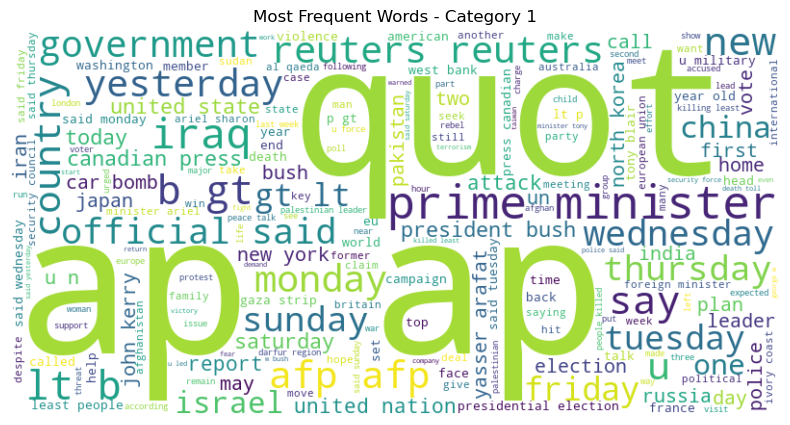

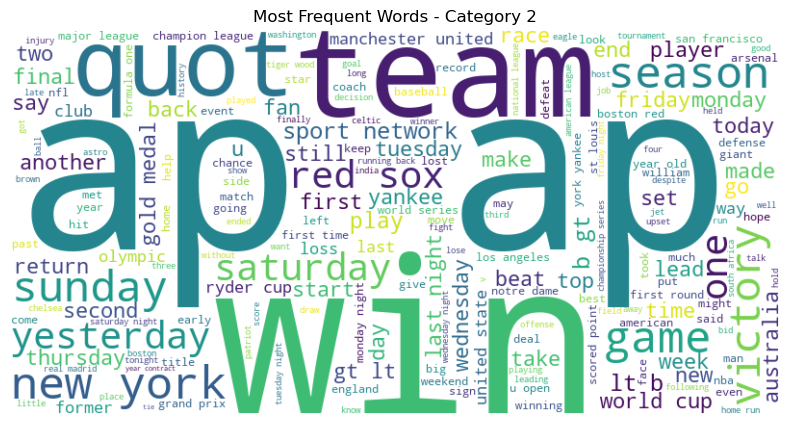

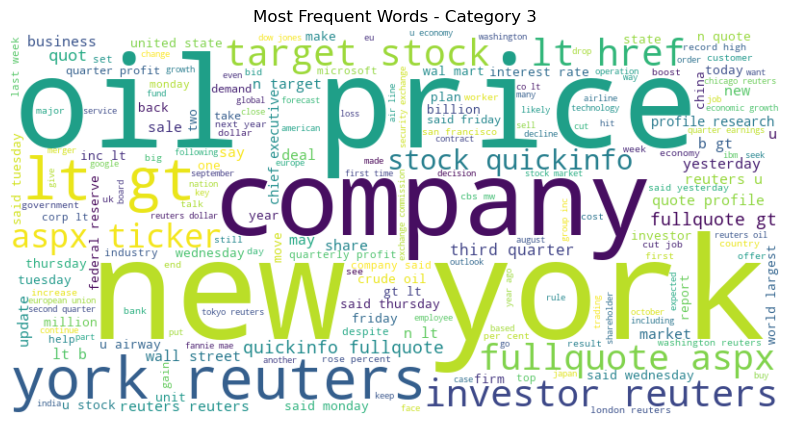

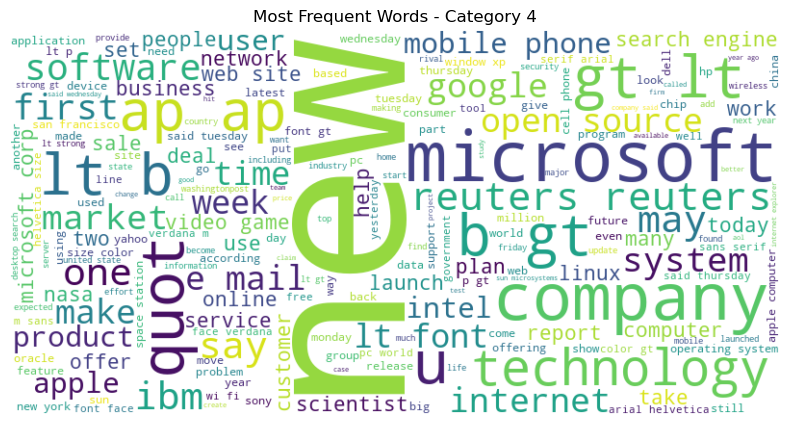

In [11]:
def plot_wordcloud(df, label):
    text = " ".join(df[df['Class Index'] == label]['clean_text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Most Frequent Words - Category {label}")
    plt.show()

for label in sorted(train_df['Class Index'].unique()):
    plot_wordcloud(train_df, label)

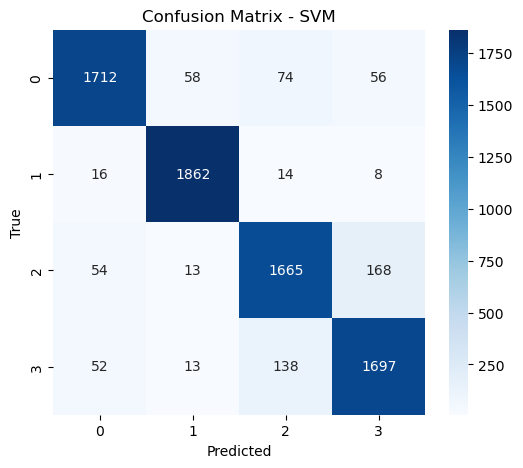


Classification Report (SVM):
              precision    recall  f1-score   support

           1       0.93      0.90      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.88      0.88      0.88      1900
           4       0.88      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [12]:
cm = confusion_matrix(y_test, svm_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report (SVM):")
print(classification_report(y_test, svm_pred))
